# Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation [1]

## Part 2. 모델 훈련과 실험

# Training Details from the Paper

- embed_size=100, hidden_size=1000 ✅ *(단, 데이터셋과 입출력 단어 집합의 크기가 모두 상대적으로 작은 것을 감안하여 각각 512로 낮추었다.)*
- num_maxouts= 500 ✅
- 순환 가중치 파라미터를 제외한 모든 파라미터는 평균이 0이고 표준편차가 0.01인 정규분포로 초기화되었다. 순환 가중치 파라미터는 동일하게 초기화한 후 좌측 특이값 행렬을 사용하였다. ❌ *(편의를 위해 모두 평균이 0이고 표준편차가 0.01인 정규분포로 초기화하였다.)*
- Adadelta와 SGD를 사용하였다. $\epsilon=10^{-6}$, $\rho=0.95$, batch_size=64 ❌ *(일반적으로 쓰는 Adam을 기본 학습률 (0.001) 로 사용하였다.)*
- *(Sequence to Sequence Learning with Neural Networks와 동일하게 실험하기 위해 입력 시퀀스를 순서로 거꾸로 하여 주었다.)*

# Training

## Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots

import math
import time

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Current device:', device)

Current device: cuda


## Load & Process the Data

In [3]:
# Download spaCy models for tokenization
!python -m spacy download en
!python -m spacy download de

     |████████████████████████████████| 12.0 MB 1.9 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
     |████████████████████████████████| 14.9 MB 13.6 MB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-py3-none-any.whl size=14907055 sha256=fedde50ae45839ba208242e00a511e56e25b7158f874eb865d71a162a20c8f33
  Stored in directory: /tmp/pip-ephem-wheel-cache-s8tlgn7a/wheels/00/66/69/cb6c921610087d2cab339062345098e30a5ceb665360e7b32a
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/de
You can now load the model via spacy.lo

In [4]:
!pip install torchdata

     |████████████████████████████████| 47 kB 2.7 MB/s 
     |████████████████████████████████| 138 kB 23.1 MB/s 
     |████████████████████████████████| 127 kB 51.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [5]:
# Import Libraries
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchtext.datasets import Multi30k
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [6]:
# Pre-defined tokens
UNK_TOKEN = '<unk>' # token representing "unknown word"
PAD_TOKEN = '<pad>' # token representing "padding"
SOS_TOKEN = '<sos>' # token representing "start of sentence"
EOS_TOKEN = '<eos>' # token representing "end of sentence"

In [7]:
src_tokenizer = get_tokenizer(tokenizer='spacy', language='de')
trg_tokenizer = get_tokenizer(tokenizer='spacy', language='en')

def yield_src_tokens(data):
  for src_sentence, _ in data:
    yield src_tokenizer(src_sentence.strip().lower())

def yield_trg_tokens(data):
  for _, trg_sentence in data:
    yield trg_tokenizer(trg_sentence.strip().lower())

# Build a vocabulary for German
train_data = Multi30k(split=('train'), language_pair=('de', 'en'))
src_vocab = build_vocab_from_iterator(yield_src_tokens(train_data), min_freq=2, specials=[UNK_TOKEN, PAD_TOKEN, SOS_TOKEN, EOS_TOKEN])
src_vocab.set_default_index(src_vocab[UNK_TOKEN]) # set the unknown token '<unk>' as default

# Build a vocabulary for English
train_data = Multi30k(split=('train'), language_pair=('de', 'en'))
trg_vocab = build_vocab_from_iterator(yield_trg_tokens(train_data), min_freq=2, specials=[UNK_TOKEN, PAD_TOKEN, SOS_TOKEN, EOS_TOKEN])
trg_vocab.set_default_index(trg_vocab[UNK_TOKEN]) # set the unknown token '<unk>' as default

/usr/local/lib/python3.7/dist-packages/torch/utils/data/datapipes/iter/combining.py:181: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  "the buffer and each child DataPipe will read from the start again.", UserWarning)


In [8]:
print(f'Vocabulary size for German: {len(src_vocab)}')
print(f'Vocabulary size for English: {len(trg_vocab)}')

Vocabulary size for German: 7855
Vocabulary size for English: 5894


In [9]:
# A function to process each batch
def collate_fn(batch):
  src_list, trg_list = [], []
  for src_sentence, trg_sentence in batch:
    src_tokens = src_tokenizer(src_sentence.strip().lower())
    src_indices = src_vocab([SOS_TOKEN] + src_tokens + [EOS_TOKEN])
    src_list.append(torch.tensor(src_indices[::-1], dtype=torch.long)) # reversed!

    trg_tokens = trg_tokenizer(trg_sentence.strip().lower())
    trg_indices = trg_vocab([SOS_TOKEN] + trg_tokens + [EOS_TOKEN])
    trg_list.append(torch.tensor(trg_indices, dtype=torch.long))
  
  src_tensor = pad_sequence(src_list, padding_value=src_vocab[PAD_TOKEN])
  trg_tensor = pad_sequence(trg_list, padding_value=trg_vocab[PAD_TOKEN])
  return src_tensor, trg_tensor

In [10]:
from torchtext.data.functional import to_map_style_dataset
BATCH_SIZE = 64

train_data, val_data, test_data = Multi30k(split=('train', 'valid', 'test'), language_pair=('de', 'en'))

train_data = to_map_style_dataset(train_data)
val_data = to_map_style_dataset(val_data)
test_data = to_map_style_dataset(test_data)

# Create dataloaders for training, validation, and test
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/datapipes/iter/combining.py:181: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  "the buffer and each child DataPipe will read from the start again.", UserWarning)


In [11]:
print('Number of the training examples:', len(train_data))
print('Number of the validation examples:', len(val_data))
print('Number of the test examples:', len(test_data))

Number of the training examples: 29001
Number of the validation examples: 1015
Number of the test examples: 1000


## Build the Model

In [12]:
!pip install git+https://github.com/deepvision-class/starter-code

  Cloning https://github.com/deepvision-class/starter-code to /tmp/pip-req-build-we1aong1
  Running command git clone -q https://github.com/deepvision-class/starter-code /tmp/pip-req-build-we1aong1
  Created wheel for Colab-Utils: filename=Colab_Utils-0.1.dev0-py3-none-any.whl size=10306 sha256=1ce0633216888a41310faa84b2327cea587449ce55683e8893e2e148ee0a7eab
  Stored in directory: /tmp/pip-ephem-wheel-cache-j0ihq2lx/wheels/eb/3c/88/465b0d78ef4a63d1f487c4208bd4691a448f05923eda0ef5f6
Successfully built Colab-Utils


In [13]:
import coutils
from coutils import extract_drive_file_id, register_colab_notebooks

In [14]:
MODEL_NOTEBOOK_LINK = "https://colab.research.google.com/drive/1TFhuT1NhrLKdkXNpq3nEwjVGkaPQtz3v"

fcn_id = extract_drive_file_id(MODEL_NOTEBOOK_LINK)
print('Google Drive file id: "%s"' % fcn_id)
register_colab_notebooks({'models': fcn_id})

from models import GRULayer, GRU, Encoder, Decoder, Seq2SeqNetwork
print('Import successful!')

Google Drive file id: "1TFhuT1NhrLKdkXNpq3nEwjVGkaPQtz3v"
name 'model' is not defined
import torch.optim as optim
# Prepare an optimizer and a loss function
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss(ignore_index=padding_index)
# reduction='mean' -> the gradients are summed and divided by batch_size

Import successful!


In [15]:
EMBED_SIZE = 512
HIDDEN_SIZE = 512
NUM_LAYERS = 1

input_size = len(src_vocab)
output_size = len(trg_vocab)
padding_index = src_vocab.lookup_indices([PAD_TOKEN])[0]

model = Seq2SeqNetwork(input_size, EMBED_SIZE, HIDDEN_SIZE, output_size,
                       NUM_LAYERS, padding_index, device=device)

## Helper Functions

In [16]:
def format_time(start_time, current_time, progress):
  elapsed = int(current_time - start_time)
  elapsed_time = f'{elapsed // 60:2d}m {elapsed % 60:2d}s'
  total = int(elapsed / progress)
  total_time = f'{total // 60:2d}m {total % 60:2d}s'
  return elapsed_time, total_time

In [17]:
# A function for training
def train(dataloader, model, optimizer, loss_fn, verbose=True, print_every=50):
  model.train()
  avg_loss = 0.
  loss_history = []
  model.train()
  for batch, (src, trg) in enumerate(dataloader):
    src, trg = src.to(device), trg.to(device)
    pred = model(src, trg)
    pred = pred[1:].view(-1, pred.size(2))
    trg = trg[1:].view(-1)
    # pred: [trg_len * batch_size, output_size], trg: [trg_len * batch_size]
    loss = loss_fn(pred, trg)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
    optimizer.step()

    avg_loss += loss.item()
    loss_history.append(loss.item())
    if verbose and batch % print_every == 0 and batch > 0:
      avg_loss /= print_every
      print(f'> [{(batch + 1) * src.size(1):5d}/{len(dataloader.dataset):5d}]',
            f'loss={avg_loss:1.4f}, ppl={math.exp(avg_loss):7.3f}')
      avg_loss = 0.
    
  return loss_history

In [18]:
# A function for evaluation
def evaluate(dataloader, model, loss_fn, verbose=True):
  avg_loss = 0.
  loss_history = []
  model.eval()
  with torch.no_grad():
    for batch, (src, trg) in enumerate(dataloader):
      src, trg = src.to(device), trg.to(device)
      pred = model(src, trg)
      pred = pred[1:trg.size(0)].view(-1, pred.size(2))
      trg = trg[1:].view(-1)
      # pred: [trg_len * batch_size, output_size], trg: [trg_len * batch_size]
      loss = loss_fn(pred, trg)

      avg_loss += loss.item()
      loss_history.append(loss.item())
  if verbose:
    avg_loss /= len(dataloader)
    print(f'> [evaluation]  loss={avg_loss:1.4f},',
          f'ppl={math.exp(avg_loss):7.3f}')
  return avg_loss, loss_history

## Train the Model

In [24]:
# Hyperparameters
BATCH_SIZE = 64

EMBED_SIZE = 512
HIDDEN_SIZE = 512
NUM_LAYERS = 1

NUM_EPOCHS = 10
# LEARNING_RATE = 0.001
MAX_GRAD_NORM = 5

In [20]:
# Create dataloaders for training, validation, and test
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [21]:
model = Seq2SeqNetwork(input_size, EMBED_SIZE, HIDDEN_SIZE, output_size,
                       NUM_LAYERS, padding_index, device=device)
for param in model.parameters():
  param.data.normal_(std=0.01)
print(f'The number of model parameter: {sum([param.numel() for param in model.parameters()]):,}')

The number of model parameter: 15,989,926


In [22]:
# Prepare an optimizer and a loss function
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss(ignore_index=padding_index)
# reduction='mean' -> the gradients are summed and divided by batch_size

In [23]:
best_val_loss = float('inf')
train_loss_history = []
val_loss_history = []
start_time = time.time()
for epoch in range(1, NUM_EPOCHS + 1):
  print('-' * 41)
  print(f'Epoch {epoch}')
  print('-' * 41)

  train_loss_history += train(train_dataloader, model, optimizer, loss_fn)
  val_loss, loss_history = evaluate(val_dataloader, model, loss_fn)
  val_loss_history += loss_history

  if epoch > NUM_EPOCHS // 2 and val_loss < best_val_loss:
    best_val_loss = val_loss
    torch.save(model.state_dict(), f'seq2seq-{val_loss * pow(10, 5):07.0f}.pth')
  
  elapsed_time, total_time = format_time(start_time, time.time(), epoch / NUM_EPOCHS)
  print('-' * 41)
  print(f'End of epoch {epoch} ({elapsed_time}/{total_time})')
  print('-' * 41)
  print()
print('Done!')

-----------------------------------------
Epoch 1
-----------------------------------------
> [ 3264/29001] loss=6.0631, ppl=429.706
> [ 6464/29001] loss=5.0094, ppl=149.809
> [ 9664/29001] loss=4.8446, ppl=127.053
> [12864/29001] loss=4.6842, ppl=108.219
> [16064/29001] loss=4.6114, ppl=100.630
> [19264/29001] loss=4.5194, ppl= 91.778
> [22464/29001] loss=4.4066, ppl= 81.989
> [25664/29001] loss=4.5256, ppl= 92.347
> [28864/29001] loss=4.5986, ppl= 99.350
> [evaluation]  loss=4.8425, ppl=126.782
-----------------------------------------
End of epoch 1 ( 1m 42s/ 8m 30s)
-----------------------------------------

-----------------------------------------
Epoch 2
-----------------------------------------
> [ 3264/29001] loss=4.3713, ppl= 79.143
> [ 6464/29001] loss=4.2108, ppl= 67.410
> [ 9664/29001] loss=4.1977, ppl= 66.532
> [12864/29001] loss=4.0995, ppl= 60.313
> [16064/29001] loss=4.1076, ppl= 60.802
> [19264/29001] loss=4.1214, ppl= 61.645
> [22464/29001] loss=4.0040, ppl= 54.818
>

In [27]:
start_epoch = 6
start_time = time.time()
for epoch in range(start_epoch, NUM_EPOCHS + 1):
  print('-' * 41)
  print(f'Epoch {epoch}')
  print('-' * 41)

  train_loss_history += train(train_dataloader, model, optimizer, loss_fn)
  val_loss, loss_history = evaluate(val_dataloader, model, loss_fn)
  val_loss_history += loss_history

  if val_loss < best_val_loss:
    best_val_loss = val_loss
    torch.save(model.state_dict(), f'seq2seq-{val_loss * pow(10, 5):07.0f}.pth')
  
  elapsed_time, total_time = format_time(start_time, time.time(), (epoch - start_epoch + 1) / (NUM_EPOCHS - start_epoch + 1))
  print('-' * 41)
  print(f'End of epoch {epoch} ({elapsed_time}/{total_time})')
  print('-' * 41)
  print()
print('Done!')

-----------------------------------------
Epoch 6
-----------------------------------------
> [ 3264/29001] loss=3.1607, ppl= 23.587
> [ 6464/29001] loss=3.1069, ppl= 22.351
> [ 9664/29001] loss=3.0626, ppl= 21.382
> [12864/29001] loss=2.9912, ppl= 19.910
> [16064/29001] loss=3.0738, ppl= 21.623
> [19264/29001] loss=3.0563, ppl= 21.248
> [22464/29001] loss=3.0274, ppl= 20.644
> [25664/29001] loss=3.0952, ppl= 22.092
> [28864/29001] loss=3.2456, ppl= 25.677
> [evaluation]  loss=4.1189, ppl= 61.491
-----------------------------------------
End of epoch 6 ( 1m 43s/ 8m 35s)
-----------------------------------------

-----------------------------------------
Epoch 7
-----------------------------------------
> [ 3264/29001] loss=2.9123, ppl= 18.399
> [ 6464/29001] loss=2.7959, ppl= 16.378
> [ 9664/29001] loss=2.7390, ppl= 15.471
> [12864/29001] loss=2.7077, ppl= 14.995
> [16064/29001] loss=2.7516, ppl= 15.668
> [19264/29001] loss=2.8252, ppl= 16.865
> [22464/29001] loss=2.7960, ppl= 16.379
>

# Experiments

## Performance on Test Dataset

In [28]:
best_model = Seq2SeqNetwork(input_size, EMBED_SIZE, HIDDEN_SIZE, output_size,
                       NUM_LAYERS, padding_index, device=device)
best_model.load_state_dict(torch.load('best-model.pth')) # at epoch 10

<All keys matched successfully>

In [29]:
_ = evaluate(test_dataloader, best_model, loss_fn)

> [evaluation]  loss=4.1038, ppl= 60.567


## PCA Projection of Word Embedding

In [36]:
specials_indices = src_vocab.lookup_indices([UNK_TOKEN, PAD_TOKEN, SOS_TOKEN, EOS_TOKEN])
print(specials_indices)

indices = torch.arange(4, 4 + 100)
tokens = src_vocab.lookup_tokens(indices.tolist())
print(*tokens[:10])

[0, 1, 2, 3]
. ein einem in eine , und mit auf mann


In [40]:
input = indices.view(1, 100) # [seq_len, batch_size]

best_model.eval()
embedded = best_model.encoder.embedding(input.to(device))
print(embedded.shape)

torch.Size([1, 100, 512])


In [41]:
embedded = embedded.squeeze(0)
U, S, V = torch.pca_lowrank(embedded)
principal_components = torch.matmul(embedded, V[:, :2]) # project into 2D
principal_components.shape

torch.Size([100, 2])

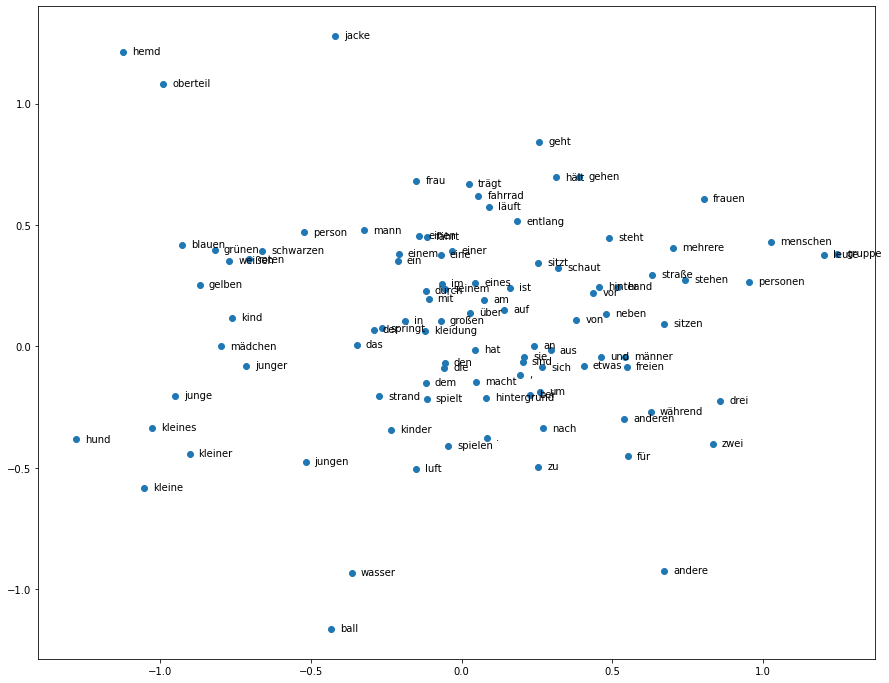

In [48]:
fig, ax = plt.subplots(figsize=(15, 12))

x = [principal_components[i, 0].cpu().detach() for i in range(principal_components.size(0))]
y = [principal_components[i, 1].cpu().detach() for i in range(principal_components.size(0))]
ax.scatter(x, y)

# printed in English for understanding but encoded in "German"
for i in range(principal_components.size(0)):
  ax.annotate(tokens[i], (x[i] + 0.03, y[i] - 0.01))

In [49]:
specials_indices = trg_vocab.lookup_indices([UNK_TOKEN, PAD_TOKEN, SOS_TOKEN, EOS_TOKEN])
print(specials_indices)

indices = torch.arange(4, 4 + 100)
tokens = trg_vocab.lookup_tokens(indices.tolist())
print(*tokens[:10])

[0, 1, 2, 3]
a . in the on man is and of with


In [53]:
input = indices.view(1, 100) # [seq_len, batch_size]

best_model.eval()
embedded = best_model.decoder.embedding(input.to(device))
print(embedded.shape)

torch.Size([1, 100, 512])


In [54]:
embedded = embedded.squeeze(0)
U, S, V = torch.pca_lowrank(embedded)
principal_components = torch.matmul(embedded, V[:, :2]) # project into 2D
principal_components.shape

torch.Size([100, 2])

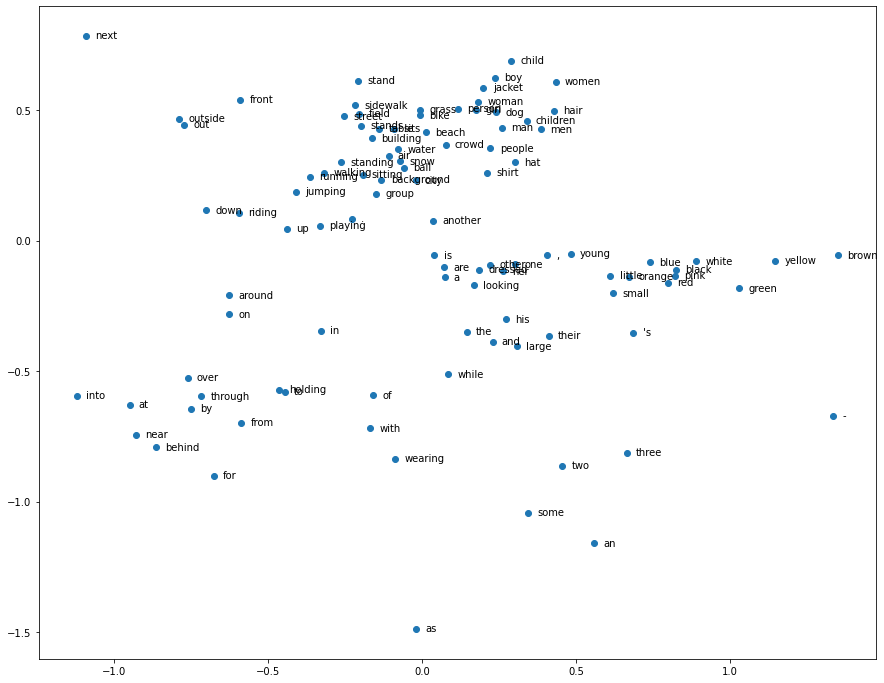

In [55]:
fig, ax = plt.subplots(figsize=(15, 12))

x = [principal_components[i, 0].cpu().detach() for i in range(principal_components.size(0))]
y = [principal_components[i, 1].cpu().detach() for i in range(principal_components.size(0))]
ax.scatter(x, y)

# printed in English for understanding but encoded in "German"
for i in range(principal_components.size(0)):
  ax.annotate(tokens[i], (x[i] + 0.03, y[i] - 0.01))

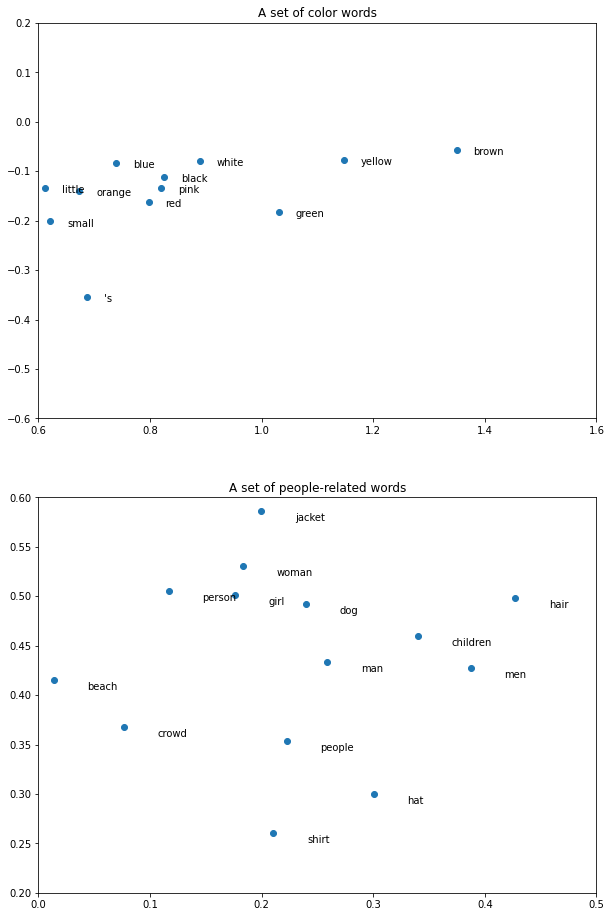

In [75]:
_, axes_list = plt.subplots(nrows=2, ncols=1, figsize=(10, 16))

# a set of color words
axes = axes_list[0]
x_range, y_range = (0.6, 1.6), (-0.6, 0.2)

x = principal_components[:, 0].tolist()
y = principal_components[:, 1].tolist()
axes.scatter(x, y)
axes.set_title('A set of color words')
axes.set_xlim(x_range)
axes.set_ylim(y_range)

# for i in range(principal_components.size(0)):
#   axes.annotate(tokens[i], (x[i] + 0.03, y[i] - 0.01))
for i in range(len(x)):
  if x_range[0] <= x[i] <= x_range[1] and y_range[0] <= y[i] <= y_range[1]:
    axes.annotate(tokens[i], (x[i] + 0.03, y[i] - 0.01))

# a set of people-related words
axes = axes_list[1]
x_range, y_range = (0, 0.5), (0.2, 0.6)

x = principal_components[:, 0].tolist()
y = principal_components[:, 1].tolist()
axes.scatter(x, y)
axes.set_title('A set of people-related words')
axes.set_xlim(x_range)
axes.set_ylim(y_range)

# for i in range(principal_components.size(0)):
#   axes.annotate(tokens[i], (x[i] + 0.03, y[i] - 0.01))
for i in range(len(x)):
  if x_range[0] <= x[i] <= x_range[1] and y_range[0] <= y[i] <= y_range[1]:
    axes.annotate(tokens[i], (x[i] + 0.03, y[i] - 0.01))

## PCA Projection of Hidden States of Phrases

In [79]:
data = [
  ('von einem bis drei Monaten', 'one to three months'),
  ('der beiden Gruppen', 'of the two groups'),
  ('die beiden Gruppen', 'the two groups'),
  ('zwei Tage vor dem Tag', 'two days before'),
  ('für fast zwei Monate', 'for nearly two months'),
  ('in den letzten zwei Jahrzehnten', 'over the last two decades'),
  ('die letzten zwei Monate', 'the last two months'),
  ('ein paar Monate vor der Einführung', 'a few months before'),
  ('Nur wenige Monate vor der Einführung', 'just a few months before'),
  ('innerhalb weniger Monate', 'within a few months'),
  ('vor einigen Tagen', 'a few days ago'),
  ('ein paar Monate', 'a few months'),
  ('dass einige Tage', 'that a few days'),
  ('in den nächsten Monaten', 'in the next few months'),
  ('die nächsten sechs Monate ', 'the next six months'),
  ('die nächsten Monate', 'the next few months'),
]

src_tensor, trg_tensor = collate_fn(data)
print(src_tensor.shape)
print(src_tensor)

torch.Size([8, 16])
tensor([[   3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
            3,    3,    3,    3],
        [   0, 1338, 1338,  200,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0],
        [  43,  523,  523,   24,   18,   18,   18,   15,   15,    0,  426,  116,
          221, 1567,  413, 1567],
        [ 818,   15,   17,   27, 1063, 3330, 3330,   27,   27, 3841,   27,    5,
          528,   33, 1567,   17],
        [   6,    2,    2,    0,   85,   33,   17,    0,    0,    2,    2,    2,
            2,    7,   17,    2],
        [  22,    1,    1,   18,    2,    7,    2,  116, 4213,    1,    1,    1,
            1,    2,    2,    1],
        [   2,    1,    1,    2,    1,    2,    1,    5,  811,    1,    1,    1,
            1,    1,    1,    1],
        [   1,    1,    1,    1,    1,    1,    1,    2,    2,    1,    1,    1,
            1,    1,    1,    1]])


In [83]:
torch.sum(src_tensor == 0, dim=0)

tensor([1, 0, 0, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1])

In [86]:
output, hidden, summary = best_model.encode(src_tensor.to(device))
last_hidden = hidden[best_model.num_rnn_layers-1] # [batch_size, hidden_size]
U, S, V = torch.pca_lowrank(last_hidden)
principal_components = torch.matmul(last_hidden, V[:, :2]) # project into 2D
principal_components.shape

torch.Size([16, 2])

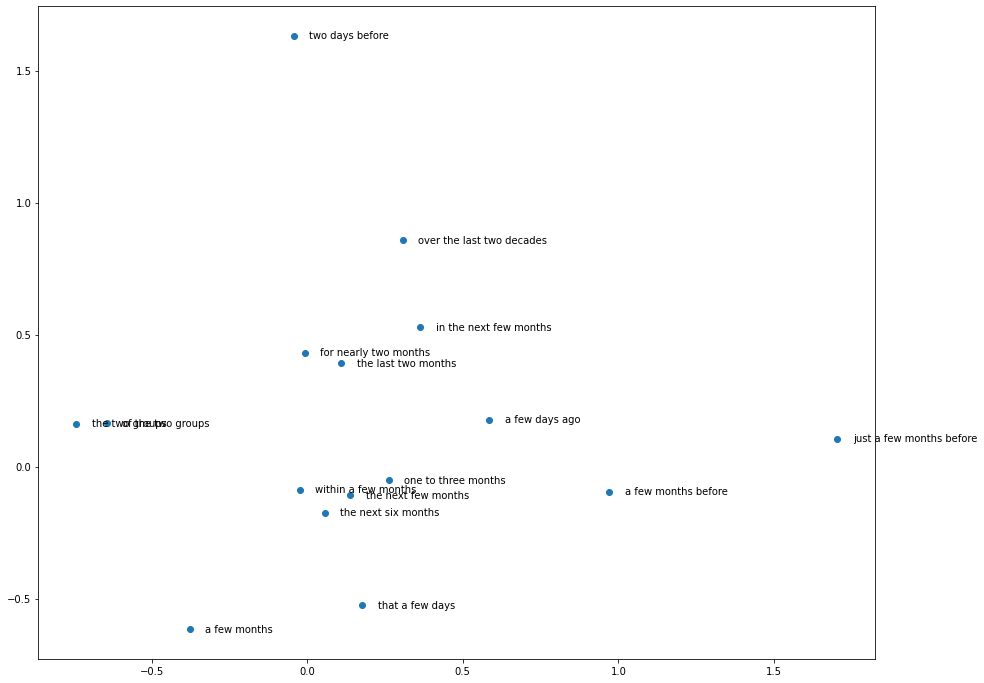

In [91]:
fig, ax = plt.subplots(figsize=(15,12))

x = principal_components[:, 0].tolist()
y = principal_components[:, 1].tolist()
ax.scatter(x, y)

# printed in English for understanding but encoded in "German"
for i in range(principal_components.size(0)):
  ax.annotate(data[i][1], (x[i] + 0.05, y[i] - 0.01))

## Example Translations

In [76]:
BATCH_SIZE = 5
newtrain_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)
src_specials = src_vocab([PAD_TOKEN, SOS_TOKEN, EOS_TOKEN])
trg_specials = trg_vocab([PAD_TOKEN, SOS_TOKEN, EOS_TOKEN])

best_model.eval()
with torch.no_grad():
  for batch, (src, trg) in enumerate(newtrain_dataloader):
    src, trg = src.to(device), trg.to(device)
    pred = best_model(src, trg) # pred: [max_seq_len, batch_size, output_size]

    src_sentences = [[src[j, i] for j in range(src.size(0)) if src[j, i] not in src_specials] for i in range(BATCH_SIZE)]
    src_sentences = [src_vocab.lookup_tokens(sentence[::-1]) for sentence in src_sentences] # reversed!
    src_sentences = [' '.join(sentence) for sentence in src_sentences] # reversed!

    trg_sentences = [[trg[j, i] for j in range(trg.size(0)) if trg[j, i] not in trg_specials] for i in range(BATCH_SIZE)]
    trg_sentences = [trg_vocab.lookup_tokens(sentence) for sentence in trg_sentences]
    trg_sentences = [' '.join(sentence) for sentence in trg_sentences]

    pred_sentences = [[pred[j, i, :].argmax() for j in range(pred.size(0)) if pred[j, i, :].argmax() not in trg_specials] for i in range(BATCH_SIZE)]
    pred_sentences = [trg_vocab.lookup_tokens(sentence) for sentence in pred_sentences]
    pred_sentences = [' '.join(sentence) for sentence in pred_sentences]

    for src, trg, pred in zip(src_sentences, trg_sentences, pred_sentences):
      print('Input German:     ', src)
      print('Target English:   ', trg)
      print('Predicted English:', pred)
      print()
    break

Input German:      zwei junge weiße männer sind im freien in der nähe vieler büsche .
Target English:    two young , white males are outside near many bushes .
Predicted English: <unk> two young boys in uniforms stand outside a a .

Input German:      mehrere männer mit schutzhelmen bedienen ein <unk> .
Target English:    several men in hard hats are operating a giant pulley system .
Predicted English: <unk> several men men wearing orange vests and safety vests work on a street .

Input German:      ein kleines mädchen klettert in ein spielhaus aus holz .
Target English:    a little girl climbing into a wooden playhouse .
Predicted English: <unk> a little girl is climbing a rock in a backyard .

Input German:      ein mann in einem blauen hemd steht auf einer leiter und putzt ein fenster .
Target English:    a man in a blue shirt is standing on a ladder cleaning a window .
Predicted English: <unk> a man in a blue shirt is a a on a wall of a .

Input German:      zwei männer stehen am h

In [77]:
BATCH_SIZE = 5
newtest_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)
src_specials = src_vocab([PAD_TOKEN, SOS_TOKEN, EOS_TOKEN])
trg_specials = trg_vocab([PAD_TOKEN, SOS_TOKEN, EOS_TOKEN])

best_model.eval()
with torch.no_grad():
  for batch, (src, trg) in enumerate(newtest_dataloader):
    src, trg = src.to(device), trg.to(device)
    pred = best_model(src, trg) # pred: [max_seq_len, batch_size, output_size]

    src_sentences = [[src[j, i] for j in range(src.size(0)) if src[j, i] not in src_specials] for i in range(BATCH_SIZE)]
    src_sentences = [src_vocab.lookup_tokens(sentence[::-1]) for sentence in src_sentences] # reversed!
    src_sentences = [' '.join(sentence) for sentence in src_sentences] # reversed!

    trg_sentences = [[trg[j, i] for j in range(trg.size(0)) if trg[j, i] not in trg_specials] for i in range(BATCH_SIZE)]
    trg_sentences = [trg_vocab.lookup_tokens(sentence) for sentence in trg_sentences]
    trg_sentences = [' '.join(sentence) for sentence in trg_sentences]

    pred_sentences = [[pred[j, i, :].argmax() for j in range(pred.size(0)) if pred[j, i, :].argmax() not in trg_specials] for i in range(BATCH_SIZE)]
    pred_sentences = [trg_vocab.lookup_tokens(sentence) for sentence in pred_sentences]
    pred_sentences = [' '.join(sentence) for sentence in pred_sentences]

    for src, trg, pred in zip(src_sentences, trg_sentences, pred_sentences):
      print('Input German:     ', src)
      print('Target English:   ', trg)
      print('Predicted English:', pred)
      print()
    break

Input German:      ein mann mit einem orangefarbenen hut , der etwas <unk> .
Target English:    a man in an orange hat starring at something .
Predicted English: <unk> a man in a hat hat is holding a <unk> .

Input German:      ein boston terrier läuft über <unk> gras vor einem weißen zaun .
Target English:    a boston terrier is running on lush green grass in front of a white fence .
Predicted English: <unk> a dog is running through a field with a red in its mouth . .

Input German:      ein mädchen in einem karateanzug bricht einen stock mit einem tritt .
Target English:    a girl in karate uniform breaking a stick with a front kick .
Predicted English: <unk> a girl in a blue uniform is a a a in a a .

Input German:      fünf leute in winterjacken und mit helmen stehen im schnee mit <unk> im hintergrund .
Target English:    five people wearing winter jackets and helmets stand in the snow , with <unk> in the background .
Predicted English: <unk> several people in in blue and and unifo

# References

[1] Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation [[link]](https://doi.org/10.48550/arXiv.1406.1078)